Exploring the $\chi^2$ distribution
===

Start with some model to generate random data.  <br> 
We'll use $0.2+\frac{sin(x)}{x+1}$ over the range $0\leq x<15$ <br>
Generate $N$ random numbers according to this distribution and make a histogram of the results using 30 bins. 

An easy way to generate random numbers according to an arbitrary distribution is to use rejection sampling (here's a great [decription  of the technique](https://matthewfeickert.github.io/Statistics-Notes/notebooks/simulation/Rejection-Sampling-MC.html) )

1) Make a histogram of your random distribution.  Verify that the the numbers you generated agree with the shape of the function.  Generate at least 10000 points and plot your data in a histogram with errorbars.  You can use numpy+matplotlib+etc, PyROOT, or a mix.  Think about how to appropriately normalize your function, then overlay it with the data.  The normalization depends on the number of bins, the bin range and the number of points thrown.  You may find it easier to first nromalize the area of your function to 1.0, thus turning it into a proper PDF.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from tqdm import tqdm
from numba import njit

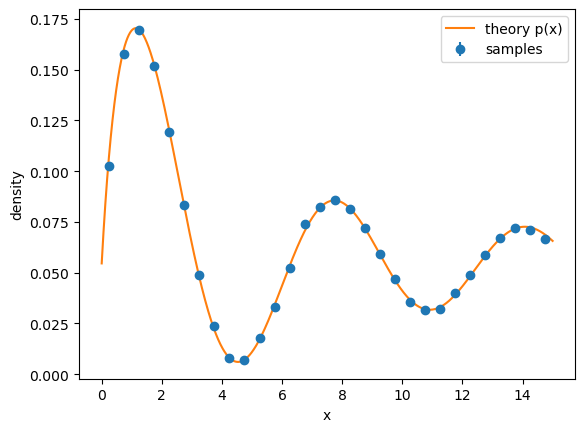

In [8]:
# target f(x)
def f(x):
    return 0.2 + np.sin(x)/(x + 1)

# domain
xmin = 0.0
xmax = 15.0

# compute normalization constant C
xs = np.linspace(xmin, xmax, 10001)
C = np.trapezoid(f(xs), x=xs)

# define p(x)
def p(x):
    return f(x)/C

# find maximum of f(x) on domain to set M
fmax = np.max(f(xs))
q = 1.0/(xmax - xmin)  # uniform proposal pdf
M = (fmax)/(q)  # since f(x) ≤ fmax => f(x) ≤ M q(x)

N = 100000  # for example
samples = []
while len(samples) < N:
    x_prop = np.random.uniform(xmin, xmax)
    u = np.random.uniform(0.0, 1.0)
    if u < f(x_prop)/(M * q):
        samples.append(x_prop)
samples = np.array(samples)

# histogram
nbins = 30
counts, bin_edges = np.histogram(samples, bins=nbins, range=(xmin, xmax))
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# density estimate
density = counts / (N * bin_width)
density_err = np.sqrt(counts) / (N * bin_width)

# overlay p(x)
x_plot = np.linspace(xmin, xmax, 1000)
p_plot = p(x_plot)

# plotting
plt.errorbar(bin_centers, density, yerr=density_err, fmt='o', label='samples')
plt.plot(x_plot, p_plot, '-', label='theory p(x)')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


2) Repeat the above experiment at least 1000 times.  For each experiment calculate the $\chi^2$ of your data with respect to your (properly normalized) model.  Plot (histogram) the $\chi^2$ distribution and compare it to the functional form of the $\chi^2(ndof=30)$ distribution.  You can find the form of the $\chi^2(ndof)$ PDF function in many places and implement it using the Gamma function or use a premade function, eg:
* [wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution)
* [scipy.stats.chi2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2)

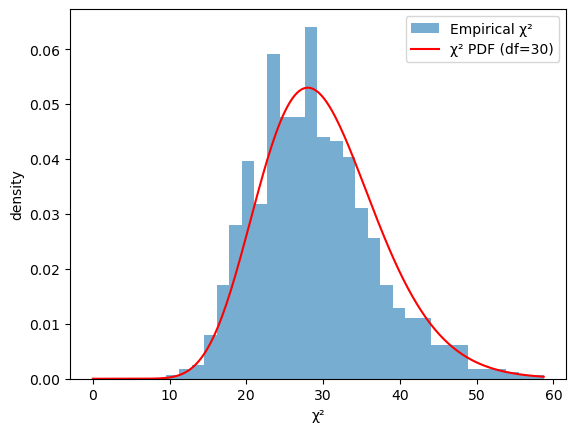

Empirical mean χ²: 28.852202215626594
Empirical var  χ²: 59.45182583637948
Theoretical mean = df = 30
Theoretical var  = 2*df = 60


In [10]:
def f(x):
    return 0.2 + np.sin(x)/(x + 1)

xmin, xmax = 0.0, 15.0
# Normalise once (as before)
xs = np.linspace(xmin, xmax, 10001)
C = np.trapezoid(f(xs), x=xs)  # use newer function
def p(x):
    return f(x) / C

# Setup bins
nbins = 30
bin_edges = np.linspace(xmin, xmax, nbins+1)
bin_centres = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# Precompute expected probabilities for each bin
prob_bins = np.array([np.trapezoid(p(np.linspace(bin_edges[j], bin_edges[j+1], 50)),
                                 x=np.linspace(bin_edges[j], bin_edges[j+1], 50))
                      for j in range(nbins)])

# Experiment parameters
N = 10000
M = 1000
chi2_vals = np.zeros(M)

# Compute proposal sampling constants
fmax = np.max(f(xs))
q = 1.0/(xmax - xmin)
Mconst = fmax / q

for i in range(M):
    # generate one experiment
    samples = []
    while len(samples) < N:
        x_prop = np.random.uniform(xmin, xmax)
        u = np.random.uniform(0.0, 1.0)
        if u < f(x_prop)/(Mconst * q):
            samples.append(x_prop)
    samples = np.array(samples)

    # histogram counts
    counts, _ = np.histogram(samples, bins=bin_edges)

    # expected counts
    E = N * prob_bins

    # avoid divisions by zero: maybe skip bins with E very small, or add small epsilon
    valid = E > 0
    chi2_vals[i] = np.sum((counts[valid] - E[valid])**2 / E[valid])

# Now plot the distribution of chi2_vals
plt.hist(chi2_vals, bins=30, density=True, alpha=0.6, label='Empirical χ²')
x_plot = np.linspace(0, np.max(chi2_vals), 200)
pdf_theory = chi2.pdf(x_plot, df=nbins)  # here df = number of bins = 30
plt.plot(x_plot, pdf_theory, 'r-', label=f'χ² PDF (df={nbins})')
plt.xlabel('χ²')
plt.ylabel('density')
plt.legend()
plt.show()

# Some summary stats
print("Empirical mean χ²:", np.mean(chi2_vals))
print("Empirical var  χ²:", np.var(chi2_vals))
print("Theoretical mean = df =", nbins)
print("Theoretical var  = 2*df =", 2*nbins)


**Only required for Phys5630**

3) Modify your code above to perform the following study. <br>
Repeat (2) for nbins = $ndof = 30, 50, 75, 100$ and calculate the reduced $\chi^2$, eg $\chi^2/ndof$ for each experiment.  Plot the mean value of the reduced $\chi^2$ with errorbars versus $ndof$.  Make a table comparing your calculations to the expected results.

ndof   Mean χ²/ndof    Std dev    Expected mean   Expected std   
----------------------------------------------------------------------


ndof loop:  25%|████████▌                         | 1/4 [00:06<00:19,  6.63s/it]

30     0.9570          0.2438     1.0000          0.2582         



ndof loop:  50%|█████████████████                 | 2/4 [00:13<00:13,  6.54s/it]

50     0.9928          0.1971     1.0000          0.2000         



ndof loop:  75%|█████████████████████████▌        | 3/4 [00:16<00:05,  5.07s/it]

75     0.9877          0.1595     1.0000          0.1633         



ndof loop: 100%|██████████████████████████████████| 4/4 [00:20<00:00,  5.05s/it]


100    0.9876          0.1441     1.0000          0.1414         


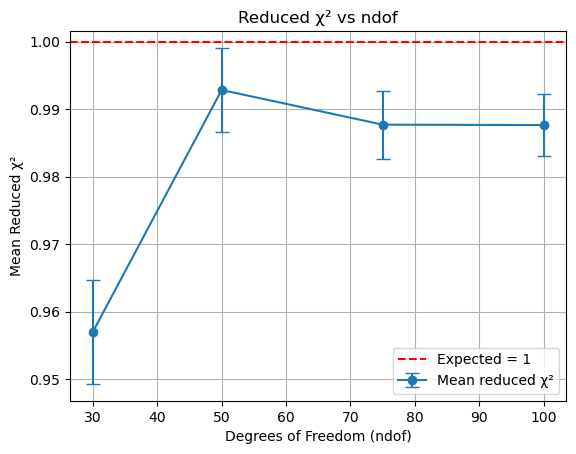

In [8]:
xmin, xmax = 0.0, 15.0
N = 10000
M = 1000
ndof_list = [30, 50, 75, 100]

@njit
def f_num(x):
    return 0.2 + np.sin(x) / (x + 1)

# Precompute xs and normalization constant C
xs = np.linspace(xmin, xmax, 10001)
C = np.trapezoid(f_num(xs), xs)

@njit
def rejection_sample_num(N, xmin, xmax, fmax, q):
    result = np.empty(N, dtype=np.float64)
    ncollected = 0
    while ncollected < N:
        for i in range(N):
            x_prop = xmin + (xmax - xmin) * np.random.rand()
            u = np.random.rand()
            if u < f_num(x_prop) * q * (xmax - xmin) / fmax:
                result[ncollected] = x_prop
                ncollected += 1
                if ncollected >= N:
                    break
    return result

@njit
def compute_chi2_num(samples, bin_edges, prob_bins, N, ndof):
    counts = np.zeros(len(prob_bins), dtype=np.int64)
    for s in samples:
        for j in range(len(bin_edges) - 1):
            if bin_edges[j] <= s < bin_edges[j + 1]:
                counts[j] += 1
                break
    chi2 = 0.0
    for j in range(len(prob_bins)):
        E = N * prob_bins[j]
        if E > 0.0:
            diff = counts[j] - E
            chi2 += diff * diff / E
    return chi2 / ndof

def expected_prob_bins(nbins):
    bin_edges = np.linspace(xmin, xmax, nbins + 1)
    probs = []
    for j in range(nbins):
        x_local = np.linspace(bin_edges[j], bin_edges[j + 1], 30)
        probs.append(np.trapezoid(f_num(x_local) / C, x_local))
    return np.array(probs), bin_edges

# Main loop
means = []
stderrs = []
fmax = np.max(f_num(xs))
q = 1.0 / (xmax - xmin)

print(f"{'ndof':<6} {'Mean χ²/ndof':<15} {'Std dev':<10} {'Expected mean':<15} {'Expected std':<15}")
print('-' * 70)

for ndof in tqdm(ndof_list, desc="ndof loop"):
    prob_bins, bin_edges = expected_prob_bins(ndof)
    chi2_vals = np.zeros(M)

    for m in tqdm(range(M), desc=f"Trials for ndof={ndof}", leave=False):
        samples = rejection_sample_num(N, xmin, xmax, fmax, q)
        chi2_vals[m] = compute_chi2_num(samples, bin_edges, prob_bins, N, ndof)

    mean = np.mean(chi2_vals)
    std = np.std(chi2_vals)
    stderr = std / np.sqrt(M)
    means.append(mean)
    stderrs.append(stderr)
    expected_std = np.sqrt(2 / ndof)

    print(f"{ndof:<6} {mean:<15.4f} {std:<10.4f} {1.0:<15.4f} {expected_std:<15.4f}")

# Plotting with error bars
plt.errorbar(ndof_list, means, yerr=stderrs, fmt='o-', capsize=5, label='Mean reduced χ²')
plt.axhline(1.0, color='r', linestyle='--', label='Expected = 1')
plt.xlabel('Degrees of Freedom (ndof)')
plt.ylabel('Mean Reduced χ²')
plt.title('Reduced χ² vs ndof')
plt.grid(True)
plt.legend()
plt.show()
